### TalTech Walk

#### consider only the walking trials 

- compute skeletal loading metrics for right and left limb (total and each axis)
- compute the frequency response for right and left limb (total)
- compute the total power

In [9]:
import os
import glob
import matplotlib.pyplot as plt
import taltech_helpers as h # contains the computations
import numpy as np
import pandas as pd
import json
from scipy.signal import correlate
from scipy.signal import medfilt, butter, filtfilt, sosfiltfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
import math

In [10]:
# note there is a difference between windows and linux when reading the file names
# read in all the clean data
base = "../../data/clean/"
data = h.read_in_clean_taltech_data(base)

reading taltech data files from ../../data/clean/
['baseline', 'flight']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']


In [11]:
exp = 2

In [12]:
# test loading computation functions
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order, sos=False):
    #nyq = 0.5 * sample_rate
    if filter_type == "band":
        if(sos):
            sos =  butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='sos', fs=sample_rate)
            return sos
        else:
            #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
            b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
            return b,a
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1], btype=filter_type, analog=False, output='ba', fs=sample_rate)
        return b,a
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)
        return b,a



def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    

def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2) # check this
    return mag.tolist()

def fft_graph_values(fft_mags, sample_rate):
    T = 1/sample_rate
    N_r =len(fft_mags)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(fft_mags)//2).tolist()
    y = fft_mags[:N_r]
    
    return [x,y]
# computes the actual loading value
def compute_loading_intensity(fft_magnitudes, sampling_frequency, high_cut_off):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(fft_magnitudes)))))
    LI = 0
    fs = sampling_frequency
    fc = high_cut_off
    kc = int((fftpoints/fs)* fc) + 1

    magnitudes = fft_magnitudes

    f = []
    for i in range(0, int(fftpoints/2)+1):
        f.append((fs*i)/fftpoints)

    for k in range(0, kc):
        LI = LI + (magnitudes[k] * f[k])

    return LI
def compute_skeletal_loading(accel_x, accel_y, accel_z, sampling_rate, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  
    accel_y = accel_y.to_numpy()  
    accel_z = accel_z.to_numpy()  
    
    # compute the magnitude vector
    a_mag = vector_magnitude([accel_x, accel_y, accel_z])
    # filter the magnitude
    filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
    # compute the frequency response
    fft_mag = compute_fft_mag(filtered_mag)
    #fft_graph = compute_frequency_response(df, sampling_rate, b,a )
    # compute the loading intensity
    li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)

def compute_skeletal_loading_metrics(df, sampling_rate, lc_off, hc_off, filter_order, filter_type):
    # extract the axes
    a_x = df["X"]
    a_y = df["Y"]
    a_z = df["Z"]

    # total loading
    total_li = compute_skeletal_loading(a_x, a_y, a_z, 
                                        sampling_rate, 
                                        lc_off, 
                                        hc_off, 
                                        filter_order, filter_type)


def filter_signal_by_sos(sos, signal):
    return sosfiltfilt(sos, signal)


def condition_an_axis(signal_df, f_params):
    #convert to numpy array
    s = signal_df.to_numpy()
    # filter the signal
    sos = build_filter((f_params["lc_off"], f_params["hc_off"]), 
                       f_params["sampling_rate"],
                       f_params["filter_type"], f_params["filter_order"], 
                       sos=True)
    s_filtered = filter_signal_by_sos(sos, s)
    # remove the median
    median_value = np.median(s_filtered)
    signal_centered = s_filtered - median_value
    return signal_centered

def condition_magnitude(x,y,z, f_params):

    mag = h.vector_magnitude([x, y, z])
    # filter the signal
    sos = build_filter((f_params["lc_off"], f_params["hc_off"]), 
                       f_params["sampling_rate"],
                       f_params["filter_type"], f_params["filter_order"], 
                       sos=True)
    filtered_mag = filter_signal_by_sos(sos, mag)
    # remove the median
    median_value = np.median(filtered_mag)
    signal_centered = filtered_mag - median_value
    return signal_centered

def compute_hf_vibration_signal(df, f_params, use_mag):
    print("computing vibration signal")
    a_x = df["X"]
    a_y = df["Y"]
    a_z = df["Z"]

    if(use_mag):
        print("using magntidue vector")
        accel_x = a_x.to_numpy()  
        accel_y = a_y.to_numpy()  
        accel_z = a_z.to_numpy()  
    
        # not use the magnitue - introduces noise
        mag = condition_magnitude(accel_x, accel_y, accel_z, f_params)
        
        return mag
    else:
        print("using individual axes")
        x_conditioned = condition_an_axis(a_x, f_params)
        y_conditioned = condition_an_axis(a_y, f_params)
        z_conditioned = condition_an_axis(a_z, f_params)

        return [x_conditioned, y_conditioned, z_conditioned]
    

In [13]:
# it has been shown by student groups that there is no signal above 2kHz
filter_params = {
    "sampling_rate" : 6000,
    "lc_off" : 100,
    "hc_off" : 1000,
    "filter_order" : 5,
    "filter_type" : "band",
    "freq_min" : 50,
    "freq_max" : 1000,
}

computing vibration signal
using individual axes
computing vibration signal
using individual axes


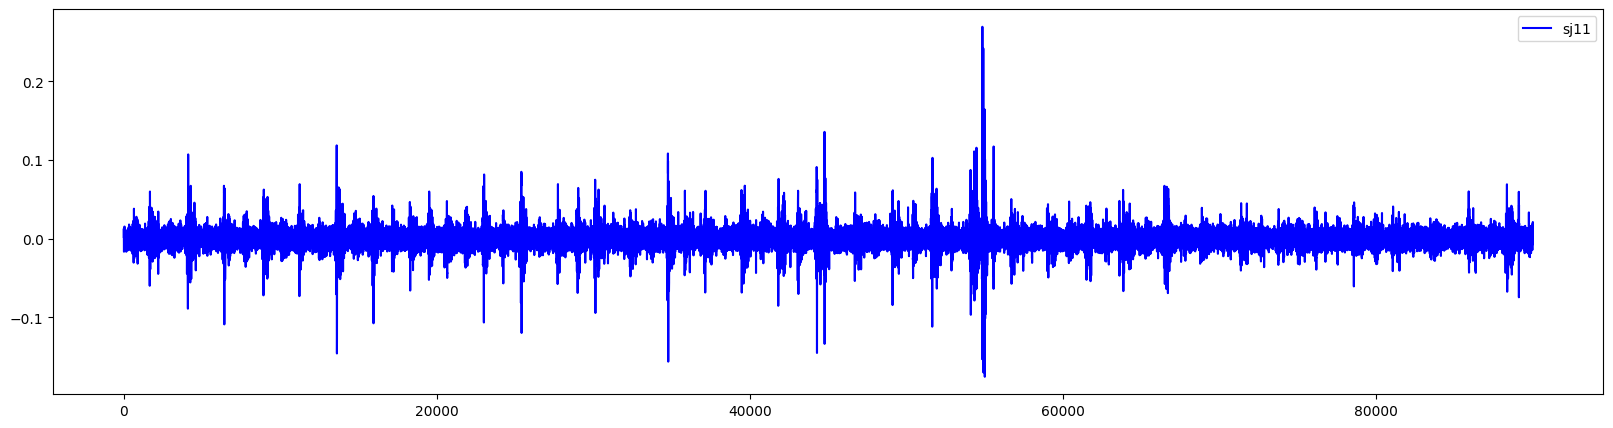

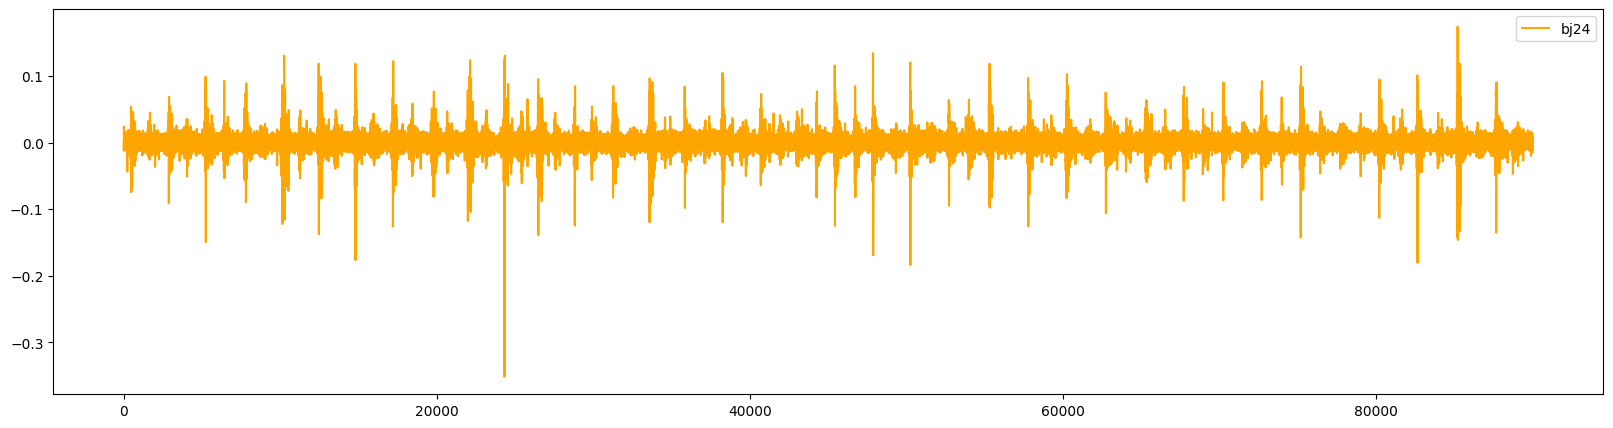

In [14]:
def minmax_normalize(signal):
    sig = np.array(signal)
    data_min = np.min(sig)
    data_max = np.max(sig)
    return (2 * (sig - data_min) / (data_max - data_min) - 1).tolist()
    
env = "flight"
exp = 1
use_with_mag = False

# clear difference here
s="sr7"
b="br23"

s="sj11"
b="bj24"
    
df_s = data[env][f"exp{str(exp)}"]["shoes"][s]
df_b = data[env][f"exp{str(exp)}"]['barefoot'][b]

s_sig = compute_hf_vibration_signal(df_s, filter_params, use_mag=use_with_mag)
b_sig = compute_hf_vibration_signal(df_b, filter_params, use_mag=use_with_mag)

#s_sig = minmax_normalize(s_sig)
#b_sig = minmax_normalize(b_sig)

if(use_with_mag):
    print("plotting magnitude")
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(s_sig, color="blue", label=f"{s}")
    ax.legend()
    
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(b_sig, color="orange", label=f"{b}")
    
    ax.legend()
    
else:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(s_sig[0], color="blue", label=f"{s}")
    ax.legend()
    
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(b_sig[0], color="orange", label=f"{b}")
    ax.legend()
  
    

In [ ]:
# test fft
sampling_rate = filter_params["sampling_rate"]
s_fft_mag = compute_fft_mag(s_sig)
b_fft_mag = compute_fft_mag(b_sig)
s_graph = fft_graph_values(s_fft_mag, sampling_rate)
b_graph = fft_graph_values(b_fft_mag, sampling_rate)

s_freqs = np.array(s_graph[0])  # Convert list to a NumPy array
b_freqs = np.array(b_graph[0])
# Create a mask for the range
s_mask = (s_freqs >= filter_params["freq_min"]) & (s_freqs <= filter_params["freq_max"])
b_mask = (b_freqs >= filter_params["freq_min"]) & (b_freqs <= filter_params["freq_max"])
# Use the mask to filter frequencies and corresponding magnitudes
s_filtered_freqs = s_freqs[s_mask]
b_filtered_freqs = b_freqs[b_mask]

s_filtered_fft_mag  = np.array(s_graph[1])[s_mask]  
b_filtered_fft_mag  = np.array(b_graph[1])[b_mask] 


fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(s_filtered_freqs, s_filtered_fft_mag, color="red", label=f"{s}")
ax[1].plot(b_filtered_freqs, b_filtered_fft_mag, color="blue", label=f"{b}")
ax[0].legend()
ax[1].legend()

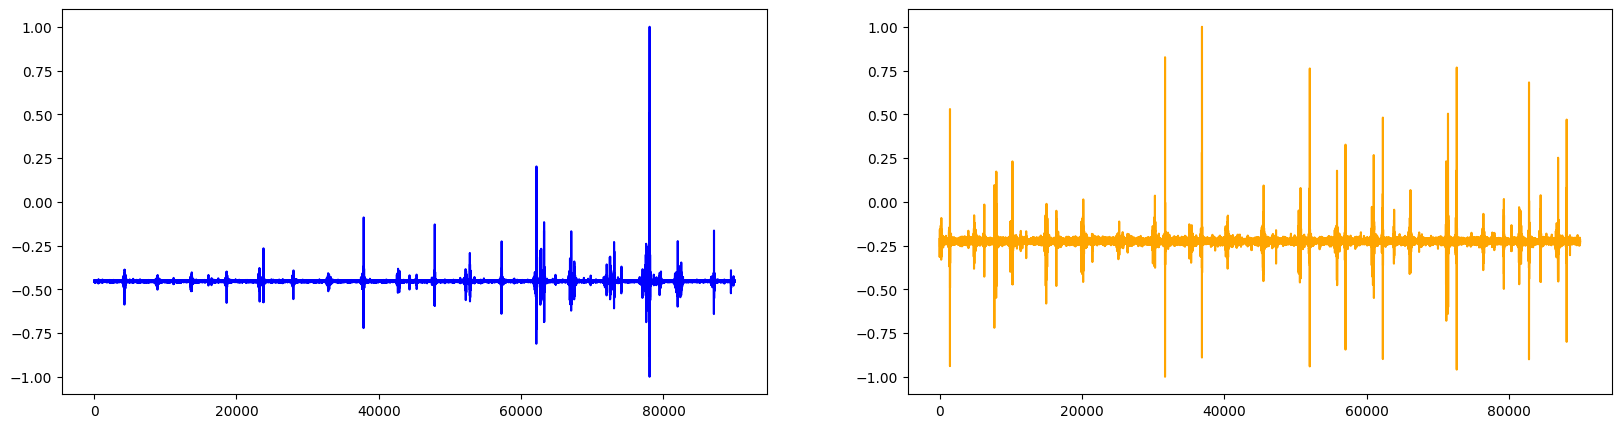

In [10]:
## sonfiy the signals in the most raw fashion

#simple method that is really loud and noisy
import soundfile as sf

fs = filter_params['sampling_rate']  # Original sampling rate of acceleration data

# mapping to higher frequency range
#s_frequencies = 1000 + (10000 - 1000) * np.array(s_sig)
#b_frequencies = 1000 + (10000 - 1000) * np.array(b_sig)

# map to log scale
#s_frequencies = filter_params["freq_min"] * (np.log1p(s_sig) / np.log(1 + np.max(s_sig)))
#b_frequencies = filter_params["freq_min"] * (np.log1p(b_sig) / np.log(1 + np.max(b_sig)))

s_frequencies = s_sig
b_frequencies = b_sig

fig, ax = plt.subplots(1,2, figsize=(20, 5))
#ax[0].plot(s_sig, color="blue")
ax[0].plot(s_frequencies, color="blue")
ax[1].plot(b_frequencies, color="orange")

# Write to an audio file
sf.write('Audio/basic/basic_sonfiy_s.wav', s_frequencies, fs)
sf.write('Audio/basic/basic_sonfiy_b.wav', b_frequencies, fs)

In [131]:
import soundfile as sf
from scipy.signal import fftconvolve

# Parameters
fs = sampling_rate  # Sampling rate of the output audio
freq_min = 100  # Minimum frequency in Hz
freq_max = 2000  # Maximum frequency in Hz
duration = len(s_sig) / fs  # Duration of the signal in seconds
t = np.linspace(0, duration, len(s_sig), endpoint=False)  # Time vector

def expand_scale(scale, freq_min, freq_max):
    """
    Expands a musical scale to cover the desired frequency range.

    Parameters:
    - scale: Base scale frequencies in Hz.
    - freq_min: Minimum frequency for the expanded scale.
    - freq_max: Maximum frequency for the expanded scale.

    Returns:
    - expanded_scale: The expanded scale frequencies covering the range.
    """
    expanded_scale = []
    for octave in range(int(np.log2(freq_max / freq_min)) + 1):
        octave_scale = [freq * (2 ** octave) for freq in scale if freq * (2 ** octave) <= freq_max]
        expanded_scale.extend(octave_scale)
    return np.array([freq for freq in expanded_scale if freq >= freq_min])


def signal_to_audio(signal, freq_min, freq_max, sampling_rate, scale=None):

    # Normalize signal to 0-1 range
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    # Map signal values to frequency range
    frequencies = freq_min + (freq_max - freq_min) * normalized_signal
    
    if scale:
        # Ensure the scale is sorted
        scale = np.sort(np.array(scale))
        
        # Map frequencies to the nearest values in the scale
        frequencies = np.array([scale[np.abs(scale - freq).argmin()] for freq in frequencies])

    # Generate an audio waveform using frequency modulation
    audio_waveform = np.sin(2 * np.pi * np.cumsum(frequencies) / sampling_rate)
    return audio_waveform




def add_harmonics(base_wave, frequencies, sampling_rate, harmonics=[1.0, 0.5, 0.25]):
    audio = base_wave
    for harmonic in harmonics:
        harmonic_wave = np.sin(2 * np.pi * harmonic * np.cumsum(frequencies) / sampling_rate)
        audio += harmonic_wave * (1 / harmonic)  # Reduce amplitude for higher harmonics
    return audio / (1 + sum(1 / h for h in harmonics))  # Normalize

def add_reverb(audio, ir):
    return fftconvolve(audio, ir, mode='full')[:len(audio)]



# Define C major scale frequencies (in Hz)
c_major_scale = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88]  # C4 to B4


# Generate audio for both signals
freq_min = filter_params["freq_min"]
freq_max = filter_params["freq_max"]


# Generate the base wave
s_audio= signal_to_audio(s_sig, freq_min, freq_max, fs,  )
b_audio = signal_to_audio(b_sig, freq_min, freq_max, fs, )



# Add harmonics
s_audio = add_harmonics(s_audio_base, freq_min + (freq_max - freq_min) * s_sig, fs)
b_audio = add_harmonics(b_audio_base, freq_min + (freq_max - freq_min) * b_sig, fs)

#impulse_response = np.exp(-np.linspace(0, 1, int(fs * 0.5)))  # Simulated reverb IR

#s_audio = add_reverb(s_audio_base, impulse_response)
#b_audio = add_reverb(b_audio_base, impulse_response)


# Normalize the audio to prevent clipping
s_audio /= np.max(np.abs(s_audio))
b_audio /= np.max(np.abs(b_audio))



# Write audio files
sf.write(f'exp{exp}_sonified_s_signal.wav', s_audio, fs)
sf.write(f'exp{exp}_sonified_b_signal.wav', b_audio, fs)


In [142]:
# try some  midi stuff

import numpy as np
from mido import MidiFile, MidiTrack, Message

import numpy as np
from mido import MidiFile, MidiTrack, Message

def frequency_to_midi(frequency):
    """
    Convert a frequency (in Hz) to a MIDI note number.
    
    Parameters:
    - frequency: Frequency in Hz
    
    Returns:
    - midi_note: MIDI note number corresponding to the frequency
    """
    if frequency <= 0:
        return None
    return int(69 + 12 * np.log2(frequency / 440.0))

def signal_to_midi(signal, freq_min, freq_max, sampling_rate, midi_file_name,  harmonic_amplitudes=None, note_duration=120):
    """
    Map a signal to MIDI notes with harmonics, and generate a MIDI file.

    Parameters:
    - signal: The input signal values (must be normalized between 0 and 1).
    - freq_min: Minimum frequency (in Hz).
    - freq_max: Maximum frequency (in Hz).
    - sampling_rate: Audio sampling rate (in Hz).
    - harmonic_amplitudes: List of amplitudes for each harmonic (e.g., [1.0, 0.5, 0.25]).
    - midi_file_name: Output file name for the generated MIDI file.
    
    Returns:
    - None
    """
    # Normalize signal to 0-1 range
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

    # Map signal values to frequency range
    frequencies = freq_min + (freq_max - freq_min) * normalized_signal
    
    # MIDI track
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)

    # Add MIDI events (Note On/Note Off) for each frequency in the signal
    for i, freq in enumerate(frequencies):
        midi_note = frequency_to_midi(freq)

        if midi_note is not None and 21 <= midi_note <= 108:  # Valid MIDI note range
            # Note On
            track.append(Message('note_on', note=midi_note, velocity=64, time=0))
            # Note Off after some time (adjust time as necessary for note duration)
            track.append(Message('note_off', note=midi_note, velocity=64, time=480))  # 480 ticks = 1 beat

    # Save MIDI file
    midi.save(midi_file_name)


# Define a musical scale (C Major)
c_major_scale = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88]

# Harmonic amplitudes (Fundamental, 2nd harmonic, 3rd harmonic)
harmonic_amplitudes = [1.0, 0.5, 0.25]

# Parameters
fs = sampling_rate  # Sampling rate of the output audio
freq_min = 100  # Minimum frequency in Hz
freq_max = 2000  # Maximum frequency in Hz

# Generate MIDI with scale mapping and harmonics
signal_to_midi(
    s_sig,
    freq_min,
    freq_max,
    sampling_rate,
    midi_file_name=f'exp{exp}_{s}.mid',
    #scale=c_major_scale,
    harmonic_amplitudes=harmonic_amplitudes,
    note_duration=120,  # Duration of each note in ticks (1/4 beat)
    
)

signal_to_midi(
    b_sig,
    freq_min,
    freq_max,
    sampling_rate,
    midi_file_name=f'exp{exp}_{b}.mid',
    #scale=c_major_scale,
    harmonic_amplitudes=harmonic_amplitudes,
     note_duration=120,  # Duration of each note in ticks (1/4 beat)
    
    
)


In [162]:
import numpy as np
from mido import MidiFile, MidiTrack, Message
import scipy.fftpack as fft

def acceleration_to_midi_using_fft(acceleration_data, freq_min, freq_max, sampling_rate, midi_file_name='output_midi.mid', window_size=4096, overlap_factor=0.5, note_duration=120):
    """
    Map acceleration data to MIDI notes using FFT.
    
    Parameters:
    - acceleration_data: The input acceleration time series data.
    - freq_min: Minimum frequency (in Hz).
    - freq_max: Maximum frequency (in Hz).
    - sampling_rate: Sampling rate of the acceleration data (in Hz).
    - midi_file_name: Output file name for the generated MIDI file.
    - window_size: Number of samples to consider per "note" in the time series (FFT window size).
    - overlap_factor: Fraction of overlap between consecutive windows (0.0 means no overlap, 1.0 means 100% overlap).
    - note_duration: Duration of each note in MIDI ticks (default is 120 ticks, or 1/4 beat).
    
    Returns:
    - None
    """
    
    # Step 1: Process the acceleration data into overlapping windows
    num_samples = len(acceleration_data)
    step_size = int(window_size * (1 - overlap_factor))  # Calculate step size for overlap
    num_windows = (num_samples - window_size) // step_size + 1
    print(num_windows)
    
    midi = MidiFile()
    track = MidiTrack()
    midi.tracks.append(track)
    track.append(Message('program_change', program=40))  # MIDI program 41 for violin (GM standard)
    
    
    # Step 2: Perform FFT on each window
    for i in range(num_windows):
        # Extract the window of data
        start = i * step_size
        end = start + window_size
        window_data = acceleration_data[start:end]
        
        # Apply FFT to the window (we're interested in the positive frequencies)
        fft_result = fft.fft(window_data)
        fft_freqs = np.fft.fftfreq(window_size, 1 / sampling_rate)
        
        # Get the magnitude of the FFT result and the corresponding positive frequencies
        magnitude = np.abs(fft_result)
        positive_freqs = fft_freqs[:window_size // 2]
        positive_magnitude = magnitude[:window_size // 2]
        
        # Step 3: Find the dominant frequency in the positive frequency range
        dominant_frequency = positive_freqs[np.argmax(positive_magnitude)]
        #print(dominant_frequency)
        
        # Map the dominant frequency to the MIDI note
        if freq_min <= dominant_frequency <= freq_max:
            midi_note = frequency_to_midi(dominant_frequency)
            
            if midi_note is not None and 21 <= midi_note <= 108:  # Check valid MIDI note range
                # Note On
                track.append(Message('note_on', note=midi_note, velocity=64, time=0))
                # Note Off after the specified note duration
                track.append(Message('note_off', note=midi_note, velocity=64, time=note_duration))
    
    # Save the MIDI file
    midi.save(midi_file_name)

def frequency_to_midi(frequency):
    """
    Convert a frequency (in Hz) to a MIDI note number.
    
    Parameters:
    - frequency: Frequency in Hz.
    
    Returns:
    - MIDI note number.
    """
    if frequency <= 0:
        return None
    return int(69 + 12 * np.log2(frequency / 440.0))  # A4 = 440Hz

# Example usage:

acceleration_to_midi_using_fft(s_sig, freq_min=50, freq_max=2000, sampling_rate=6600, midi_file_name='s_acceleration_fft_midi.mid')


42
